In [19]:
import yfinance as yf

data = yf.download(tickers = "GC=F", start="2017-12-01", end="2023-06-02", interval='1d')
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,1274.099976,1288.599976,1271.000000,1278.800049,1278.800049,823
2017-12-04,1272.500000,1276.099976,1270.300049,1274.300049,1274.300049,850
2017-12-05,1275.400024,1275.800049,1260.000000,1261.599976,1261.599976,1499
2017-12-06,1264.900024,1267.800049,1261.599976,1262.800049,1262.800049,373
2017-12-07,1262.300049,1262.400024,1243.900024,1249.800049,1249.800049,358
...,...,...,...,...,...,...
2023-05-25,1943.099976,1943.099976,1943.099976,1943.099976,1943.099976,1
2023-05-26,1948.199951,1948.400024,1944.099976,1944.099976,1944.099976,166036
2023-05-30,1942.699951,1962.599976,1931.000000,1958.000000,1958.000000,37838


In [20]:
data = data.reset_index('Date', inplace=False)

In [21]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [22]:
# 2. Đọc file dữ liệu giá vàng GC=F và chia train test validate theo tỉ lệ 7:2:1
data = data[['Close']]
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [23]:
data

,Close
0,1278.800049
1,1274.300049
2,1261.599976
3,1262.800049
4,1249.800049
...,...
1379,1943.099976
1380,1944.099976
1381,1958.000000
1382,1963.900024


In [24]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8100.062, Time=1.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8097.666, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8099.396, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8099.408, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8096.605, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8101.194, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.508 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [25]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [28]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1757.90002441 1757.90002441 1757.90002441 1757.90002441 1757.90002441
 1757.90002441 1757.90002441 1757.90002441 1757.90002441 1757.90002441
 1757.90002441 1757.90002441 1757.90002441 1757.90002441 1757.90002441
 1757.90002441 1757.90002441 1757.90002441 1757.90002441 1757.90002441
 1757.90002441 1757.90002441 1757.90002441 1757.90002441 1757.90002441
 1757.90002441 1757.90002441 1757.90002441 1757.90002441 1757.90002441]


In [30]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 163.37369344232266
Testing RMSE: 99.04450428742771


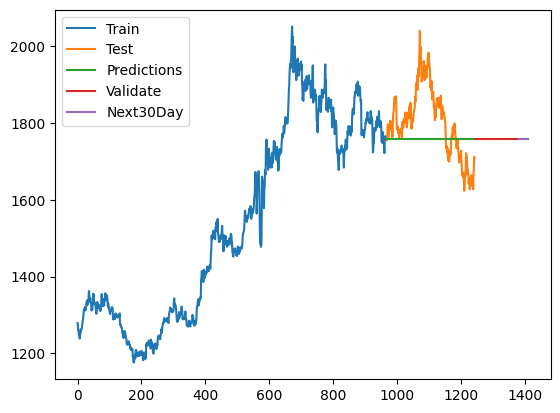

In [31]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()